In [1]:
#import packages
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/content/drive/MyDrive/8_semestr/diplom/TSLA.csv')

#print the head
df.head()
size=2600

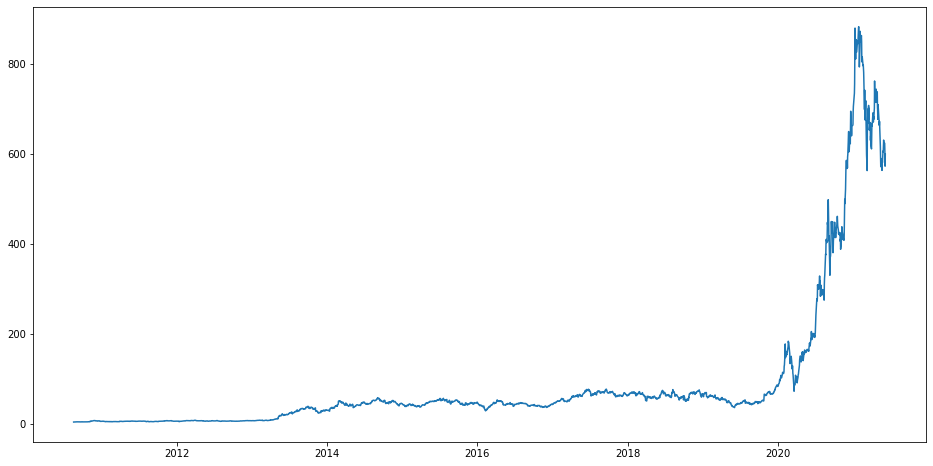

In [2]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [3]:
! pip install pmdarima

     |████████████████████████████████| 1.5MB 8.5MB/s 
     |████████████████████████████████| 9.5MB 33.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
import pmdarima as pm

data = df.sort_index(ascending=True, axis=0)

train = data[:2600]
valid = data[2600:]

training = train['Close']
validation = valid['Close']

model = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=17172.005, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=16434.691, Time=0.94 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=17152.310, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=16134.082, Time=2.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.23 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=16133.311, Time=1.72 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=16433.086, Time=0.62 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=7.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=16134.154, Time=2.51 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=16135.755, Time=6.09 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AI

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [5]:
forecast = model.predict(n_periods=117)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [6]:
print(r2_score(np.array(valid['Close']), np.array(forecast['Prediction'])))
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

-22.259791448774227


424.6182505260849

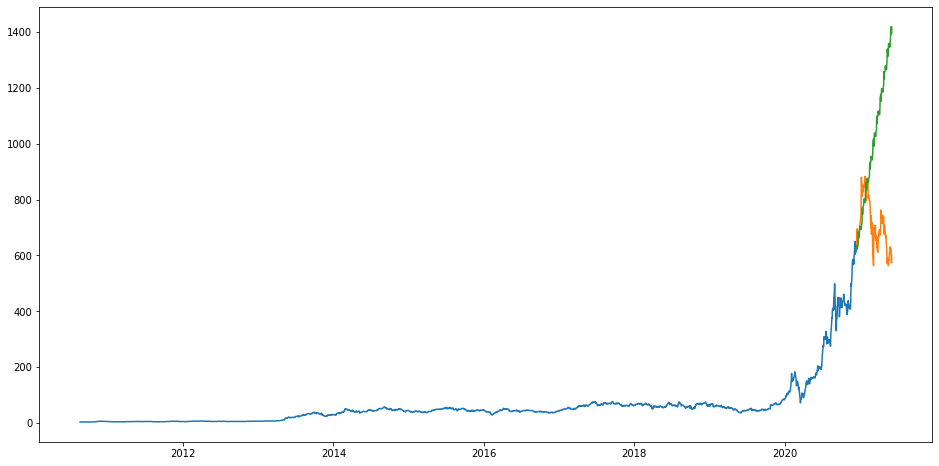

In [7]:
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

In [8]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:2600]
valid = new_data[2600:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
#rmse
forecast_valid = forecast['yhat'][2600:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
print(rms)
print(r2_score(np.array(valid['y']),np.array(forecast_valid)))

357.5562091695591
-15.492904778098758


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



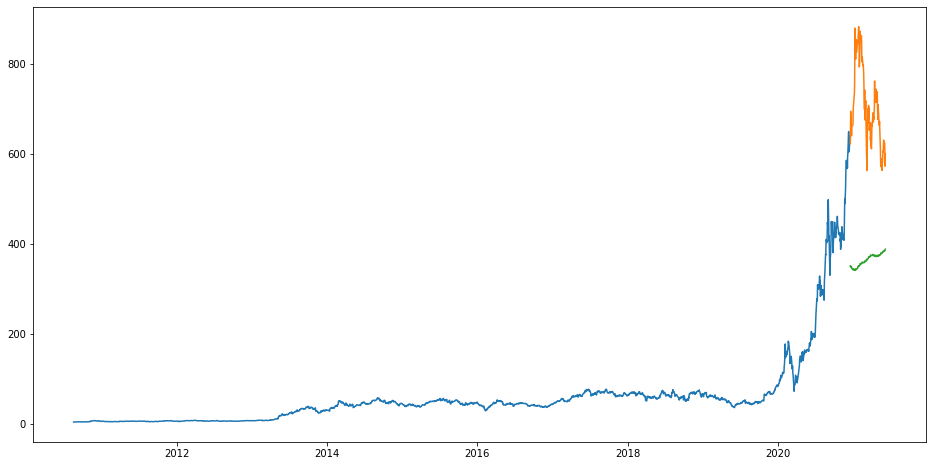

In [10]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.figure(figsize=(16,8))
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [11]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:2600,:]
valid = dataset[2600:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train, y_train, epochs = 120, batch_size = 32)
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(LSTM(units=50))
# model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=32, verbose=2)


Epoch 1/120
80/80 [==============================] - 26s 14ms/step - loss: 0.0030
Epoch 2/120
80/80 [==============================] - 1s 13ms/step - loss: 5.3683e-04
Epoch 3/120
80/80 [==============================] - 1s 13ms/step - loss: 9.3918e-04
Epoch 4/120
80/80 [==============================] - 1s 13ms/step - loss: 4.4145e-04
Epoch 5/120
80/80 [==============================] - 1s 13ms/step - loss: 6.1915e-04
Epoch 6/120
80/80 [==============================] - 1s 13ms/step - loss: 3.6788e-04
Epoch 7/120
80/80 [==============================] - 1s 13ms/step - loss: 4.7223e-04
Epoch 8/120
80/80 [==============================] - 1s 13ms/step - loss: 4.1497e-04
Epoch 9/120
80/80 [==============================] - 1s 13ms/step - loss: 4.0031e-04
Epoch 10/120
80/80 [==============================] - 1s 13ms/step - loss: 3.7034e-04
Epoch 11/120
80/80 [==============================] - 1s 13ms/step - loss: 4.6113e-04
Epoch 12/120
80/80 [==============================] - 1s 13ms/step

In [23]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
# print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# print(X_test)


In [24]:
closing_price = model.predict(X_test)
print(closing_price.shape)
closing_price = scaler.inverse_transform(closing_price)

(117, 1)


In [26]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms
print(r2_score(valid["Close"],closing_price))

0.17116422709846435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



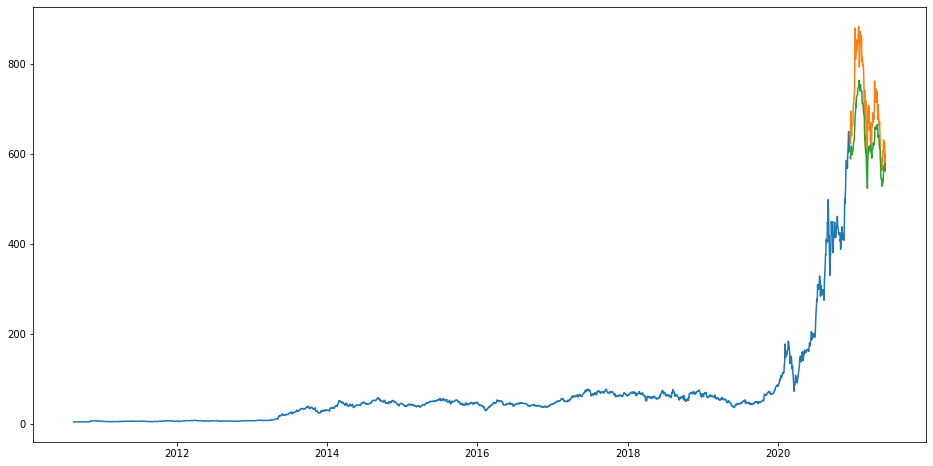

In [27]:
#for plotting
train = new_data[:2600]
valid = new_data[2600:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [28]:
from keras.layers import GRU
from keras.optimizers import SGD

my_GRU_model = Sequential()
# First GRU layer with Dropout regularisation
my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Second GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))

# Third GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Fourth GRU layer
my_GRU_model.add(GRU(units=50, activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# The output layer
my_GRU_model.add(Dense(units=1))
# Compiling the RNN
my_GRU_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
my_GRU_model.fit(x_train,y_train,epochs=100,batch_size=150, verbose=1)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predictions = my_GRU_model.predict(X_test)
GRU_predictions = scaler.inverse_transform(GRU_predictions)

Epoch 1/100
17/17 [==============================] - 5s 19ms/step - loss: 0.0118
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0091
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0070
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0059
Epoch 5/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0051
Epoch 6/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0036
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0031
Epoch 8/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0023
Epoch 9/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0016
Epoch 10/100
17/17 [==============================] - 0s 13ms/step - loss: 9.0520e-04
Epoch 11/100
17/17 [==============================] - 0s 13ms/step - loss: 6.8067e-04
Epoch 12/100
17/17 [==============================] - 0s 14ms/step - loss: 7.0232e-04
Epoch 13/100


In [29]:
# print(GRU_predictions)
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], GRU_predictions, squared=False)
print(r2_score(valid["Close"],GRU_predictions))


0.604733876915339


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



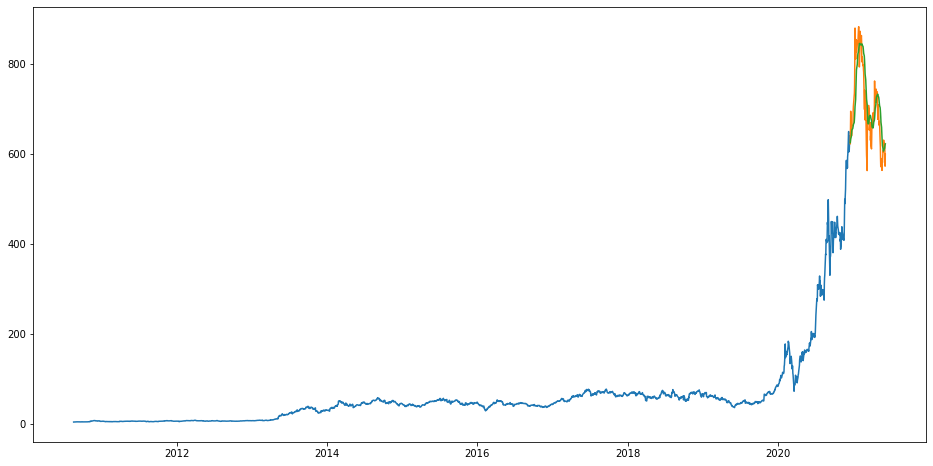

In [30]:
#for plotting
train = new_data[:2600]
valid = new_data[2600:]
valid['Predictions'] = GRU_predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [32]:
from numpy import array
x_input=scaled_data[2540:2600,:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print((temp_input))
temp2=np.array(temp_input)
print(scaler.inverse_transform(temp2.reshape(-1,1)))

[0.4781720648052776, 0.4282818928873155, 0.43673151575087577, 0.45896428608075707, 0.4747262685565757, 0.4723039696585508, 0.4836080080590537, 0.5053858956055061, 0.46777779424608634, 0.47982102328225557, 0.46651548948984206, 0.4793888713893052, 0.480093980473203, 0.4892827587183971, 0.4987217280100273, 0.5036686716745733, 0.5203290383508344, 0.5062047000819634, 0.49573084979878707, 0.48567773478811327, 0.4755678050607384, 0.4763638786467175, 0.47994613643249007, 0.4740780412857634, 0.4736800050613874, 0.4786837964222131, 0.457463138664913, 0.46293319758726365, 0.4370158224658864, 0.45119704254784304, 0.47779676060860693, 0.4744760775101395, 0.4939340120270634, 0.4846770035819474, 0.47479449989372446, 0.46239869868858996, 0.4700977472756147, 0.4639908447233209, 0.4602834737873138, 0.459817206225789, 0.49793703806491735, 0.5491463976894362, 0.5635095433638743, 0.5525239273469564, 0.5891881110796843, 0.6273193606764876, 0.6484945191243443, 0.6618683183707125, 0.6412162399266278, 0.660731

In [36]:
lst_output=[]
n_steps=60
i=0
while(i<117):
    
    if(len(temp_input)>60):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print("lst:", lst_output)

0 day input [0.81844729 0.81980711 0.82115042 0.82247746 0.82378811 0.82508272
 0.82636118 0.82762384 0.82887059 0.83010161 0.83131719 0.83251727
 0.83370209 0.83487159 0.83602613 0.83716559 0.83829027 0.83940053
 0.84049588 0.84157699 0.84264374 0.8436963  0.84473485 0.84575939
 0.84677035 0.84776765 0.84875125 0.84972167 0.8506788  0.85162288
 0.85255384 0.85347211 0.85437751 0.85527045 0.85615098 0.85701913
 0.85787511 0.85871905 0.85955119 0.86037135 0.86118007 0.86197704
 0.86276293 0.86353737 0.86430073 0.86505312 0.86579454 0.86652529
 0.8672455  0.86795515 0.86865443 0.86934364 0.87002254 0.87069154
 0.87135071 0.8720001  0.87263989 0.87327021 0.87389112 0.87450278]
0 day output [[0.77284974]]
1 day input [0.81980711 0.82115042 0.82247746 0.82378811 0.82508272 0.82636118
 0.82762384 0.82887059 0.83010161 0.83131719 0.83251727 0.83370209
 0.83487159 0.83602613 0.83716559 0.83829027 0.83940053 0.84049588
 0.84157699 0.84264374 0.8436963  0.84473485 0.84575939 0.84677035
 0.847767

In [37]:
# print(lst_output)
predictions = scaler.inverse_transform(lst_output)
# print(predictions)
# lst_output=np.array(predictions)
# print(predictions.shape)
# print((lst_output))
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], predictions, squared=False)
print(r2_score(valid["Close"],predictions))

-14.27034384151702


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



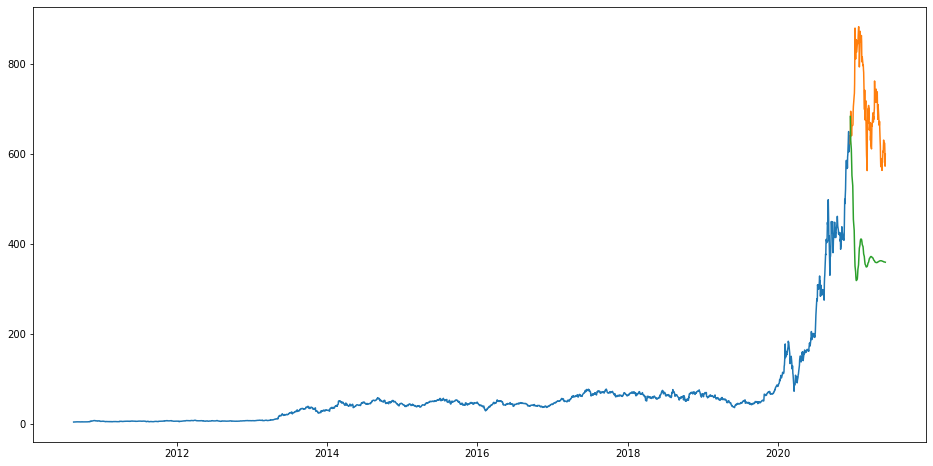

In [38]:
#for plotting
train = new_data[:2600]
valid = new_data[2600:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])